# The Schmidt-Appleman Criterion

In [1]:
from sympy import symbols, diff, log, Pow, solve, nsolve, Eq, lambdify
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, newton
import scipy.optimize as opt

### Isobaric mixing line slope (G) & T_LM

In [2]:
# Isobaric mixing line (G)

# this data are from "U. SCHUMANN, Oberpfaffenhofen" and "Esther Roosenbrand, Junzi Sun and Jacco Hoekstra"

EI_H2O = 1.223 #Emission Index of H2O [kg/kg]
c_p = 1004 #Specific heat of air [J/kgK]
eps = 0.622 #Molar mass ratio
Q = 43.2*10**6 #Heat of combustion [J/kg]
eta = 0.3 #Efficiency of combustion - eta = (F*V)/(m_f*Q) (F = thrust, V = air speed, m_f = fuel flow rate, Q = combustion heat)
p_h = 236*100 #Ambient pressure [Pa] for a given altitude

G = (EI_H2O*c_p*p_h)/(eps*Q*(1-eta)) #Isobaric mixing line [Pa/K]

print(f"G = {G:.2f} [Pa/K]")

# T_LM point

T_LM = -46.46+9.43*np.log(G-0.053)+0.720*(np.log(G-0.053))**2

print(f"T_LM = {T_LM:.2f} °C")


G = 1.54 [Pa/K]
T_LM = -42.60 °C


### Saturation vapor pressure over water curve

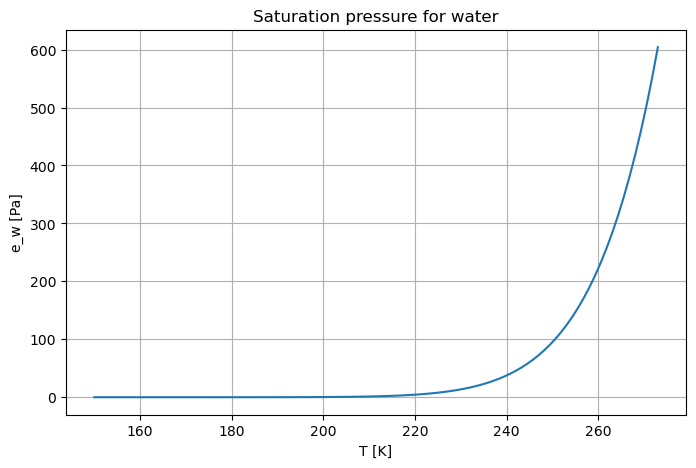

In [3]:
# Main information are extracted from the link "https://en.wikipedia.org/wiki/Goff%E2%80%93Gratch_equation" and the paper "XU Junzeng, WEI Qi, PENG Shizhang, YU Yanmei"

T_st = 373.15 #steam point saturation temperature [K]
ewater_st = 1013.25 #ewater at the steam-point pressure [hPa]

T_values = np.linspace(150, 273, 100)

def ewater1(T):
    return 10**(-7.90298*((T_st/T)-1)+5.02808*np.log10(T_st/T)-1.3816*10**(-7)*(10**(11.344*(1-(T/T_st)))-1)+8.1328*10**(-3)*(10**(-3.49149*((T_st/T)-1))-1)+np.log10(ewater_st))

ewater_values1 = ewater1(T_values)*100

# grafico ewater1

plt.figure(figsize=(8,5))
plt.plot(T_values, ewater_values1)
plt.xlabel("T [K]")
plt.ylabel("e_w [Pa]")
plt.title("Saturation pressure for water")
plt.grid(True)
plt.show()


### Saturation vapor pressure over ice curve

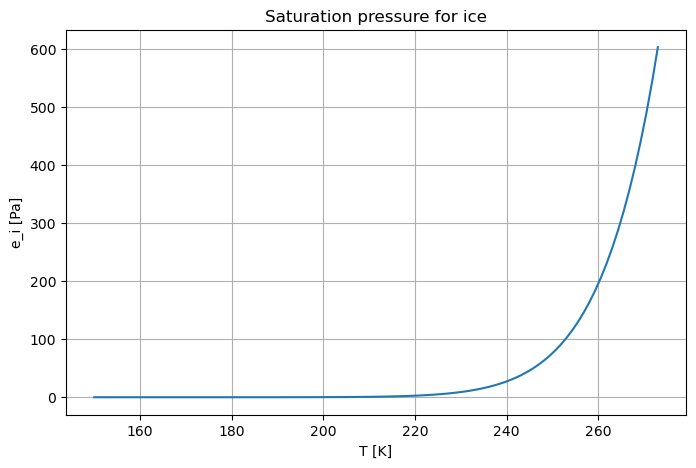

In [4]:
# Main information are extracted from the link "https://en.wikipedia.org/wiki/Goff%E2%80%93Gratch_equation" and the paper "XU Junzeng, WEI Qi, PENG Shizhang, YU Yanmei"

T0 = 273.16 #ice-point temperature [K]
eice_i = 6.1173 #eice at the ice-point temperature [hPa]

def eice1(T):
    return 10**(-9.09718*((T0/T)-1)-3.56654*np.log10(T0/T)+0.876793*(1-T/T0)+np.log10(eice_i))

eice_values1 = eice1(T_values)*100

# grafico eice1

plt.figure(figsize=(8,5))
plt.plot(T_values, eice_values1)
plt.xlabel("T [K]")
plt.ylabel("e_i [Pa]")
plt.title("Saturation pressure for ice")
plt.grid(True)
plt.show()


### Isobaric Mixing line

T_0 = 230.55 [K]
ewater1_0 = 14.39 [Pa]


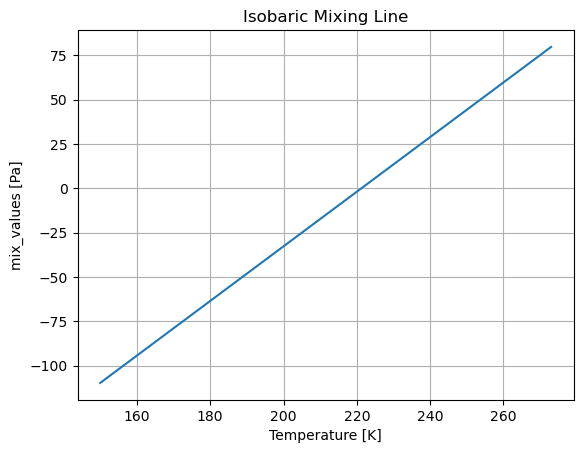

In [5]:
# Calculation of the tangent curve considering to know the point of intersection between the isobaric mixing line and the ewater1 curve

T_0 = T_LM+273.15 #[K]

print(f"T_0 = {T_0:.2f} [K]")

T = symbols('T')

ewater1 = Pow(10, (-7.90298*((T_st/T)-1) + 5.02808*log(T_st/T, 10) - 1.3816*10**(-7)*(Pow(10, 11.344*(1-(T/T_st)))-1) + 8.1328*10**(-3)*(Pow(10, -3.49149*((T_st/T)-1))-1) + log(ewater_st, 10)))

# Calculation of ewater1_0 knowing T_0

f = lambdify(T, ewater1)  # convert the sympy function to a numpy function (from simbolic to numeric)
ewater1_0 = f(T_0)*100  # evaluaetion of the function in T_0

print(f"ewater1_0 = {ewater1_0:.2f} [Pa]")

# Equation of the isobaric mixing line imponing the slope G and the passage for the point (T_0;ewater1_0)
def isobaric_mixing_line(T):
    return G*(T-T_0)+ewater1_0

mix_values = isobaric_mixing_line(T_values)

plt.plot(T_values, mix_values, label='Isobaric Mixing Line')
plt.xlabel('Temperature [K]')
plt.ylabel('mix_values [Pa]')
plt.title('Isobaric Mixing Line')
plt.grid(True)
plt.show()


##  Visualization of the geometric approach to determining the critical formation temperature 

T_LM: ([230.549070684277];[14.385120820981035])
T_LC: ([224.07482667];[4.41066836])


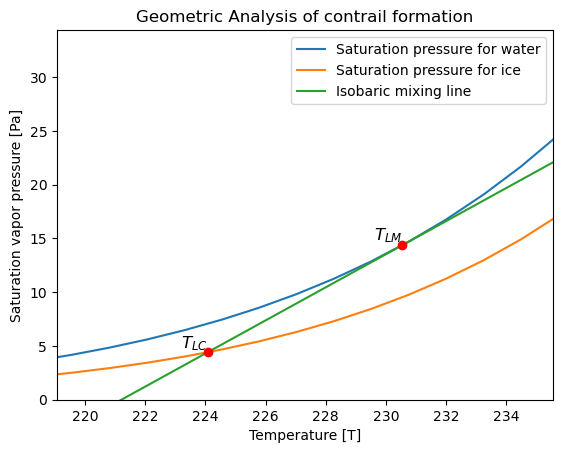

In [6]:

plt.plot(T_values, ewater_values1) 
plt.plot(T_values, eice_values1) 
plt.plot(T_values, mix_values)

plt.scatter(T_0, ewater1_0, color='red', zorder=5, label=f"Punto ({T_0}, {ewater1_0})")
plt.text(T_0, ewater1_0, '$T_{LM}$', fontsize=12, ha='right', va='bottom', color='black')

print(f"T_LM: ([{T_0}];[{ewater1_0}])")

# Calculation of the intersection point between the isobaric mixing line and the eice1 curve

def f1(T):
    return G*(T-T_0)+ewater1_0

def f2(T):
    return  10**(-9.09718*((T0/T)-1)-3.56654*np.log10(T0/T)+0.876793*(1-T/T0)+np.log10(eice_i))

# difference between the two functions

def diff(T):
    return f1(T) - f2(T)*100 # multiply by 100 to convert from hPa to Pa

# Found the intersection point using two initial guesses
x_intersect = opt.fsolve(diff, x0=[220, 250])  # x0 = initial guess
y_intersect = f1(x_intersect)

# Filter the intersection point (T<230)

mask = x_intersect < T_0  
x_filtered = x_intersect[mask]
y_filtered = y_intersect[mask]

print(f"T_LC: ({x_filtered};{y_filtered})")

plt.scatter(x_filtered, y_filtered, color='red', zorder=5)
plt.text(x_filtered, y_filtered, '$T_{LC}$', fontsize=12, ha='right', va='bottom', color='black')

plt.ylim(0, ewater1_0+20)
plt.xlim(x_filtered-5, T_0+5)
plt.xlabel("Temperature [T]")
plt.ylabel("Saturation vapor pressure [Pa]")
plt.title("Geometric Analysis of contrail formation")
plt.legend(["Saturation pressure for water", "Saturation pressure for ice", "Isobaric mixing line"])
plt.show()       

## Costruction of Schmidt-Appleman diagram

Lest: -59.43428506223242
right: -26.171818966043332


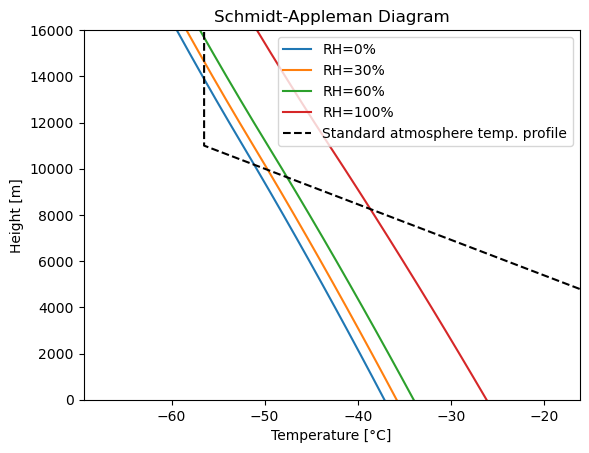

In [7]:
# Main information are extracted from the paper "Sébastien Lána, Miroslav Špáka" and "U. SCHUMANN, Oberpfaffenhofen"

p0 = 101325 # pressure at sea level [Pa]
T_sl = 288.15 # temperature at mean sea level [K]
g = 9.81 # gravity acceleration [m/s^2]
R = 287.053 # specific gas constant for dry air [J/kgK]
beta = -0.0065 # temperature gradient [K/m]
T = 216.65 # temperature [K]

h = np.linspace(0,16000,17) # height [m]

# costruction of the pressure profile

p = np.zeros_like(h)

for idx, i in enumerate(h):
    if i <= 11000:
        p[idx] = p0*(1+((beta*i)/T_sl))**(-g/(R*beta)) # this equation makes sense only until 11Kms
        p11 = p[11] # pressure at 11Kms -- ATTENTION: the position of this value on the array change if the range of h change
    else:
        p[idx] = p11*np.exp(-g/(R*T)*(i-11000)) # this equation makes sense over until 11Kms

def ewater1(T):
    return (10**(-7.90298*((T_st/T)-1)+5.02808*np.log10(T_st/T)-1.3816*10**(-7)*(10**(11.344*(1-(T/T_st)))-1)+8.1328*10**(-3)*(10**(-3.49149*((T_st/T)-1))-1)+np.log10(ewater_st)))*100            

# percentage of relative humidity

RH = [0, 0.3, 0.6, 1]

# calculation of the formation temperature of the contrail (T_LC) for different values of relative humidity (RH) combining whit the pressure profile (p)

T_LC_solution = np.zeros_like(h)
T_LC = np.zeros_like(p)

for U in RH:
    for idx2, i in enumerate(p):
        G = (EI_H2O*c_p*i)/(eps*Q*(1-eta)) # [Pa/K]
        T_LM = (-46.46+9.43*np.log(G-0.053)+0.720*(np.log(G-0.053))**2)+273.15 # [k]
        def f(T_LC):
            return -T_LC+T_LM-((ewater1(T_LM)-U*ewater1(T_LC))/G)
        def df(T_LC):
            inc = 1e-8  # increment for numerical differentiation
            return (f(T_LC+inc)-f(T_LC))/inc
        T_LC_initial = 220 # first guess [K]
        T_LC_solution[idx2] = newton(f, T_LC_initial, fprime=df, maxiter=1000)-273.15 # [°C]
    if U == 0:
        left = T_LC_solution[16] # last value of the graph
        print(f"Lest: {left}")
    if U == 1:
        right = T_LC_solution[0]
        print(f"right: {right}")

    plt.plot(T_LC_solution,h)

# calculation of the standard atmosphere temperature profile

T = np.zeros_like(h)

for idx, i in enumerate(h):
    if i <= 11000:
        T[idx] = (T_sl+beta*i)-273.15 # [°C] - until 11Kms
    else:
        T[idx] = T[11] # [°C] - over 11Kms and until 20Kms


plt.plot(T,h, label="Standard atmosphere temperature profile", color='black', linestyle='--')
plt.xlabel("Temperature [°C]")
plt.ylabel("Height [m]")
plt.xlim(left-10, right+10)
plt.ylim(0,16000)
plt.legend(["RH=0%", "RH=30%", "RH=60%", "RH=100%", "Standard atmosphere temp. profile"])
plt.title("Schmidt-Appleman Diagram")
plt.show()